<a id='home'></a>
### Contents

[Imports](#Imports)

[Data Loading](#DataLoading)

[Training Catboost](#TrainingCatboost)

   - [RMSE loss](#RMSEloss)
   
   - [Custom RMSE loss](#CustomRMSEloss)
   
   - [Poisson loss](#Poissonloss)
   
   - [Custom Poisson loss](#CustomPoissonloss)
   
[Focal loss example](#Focallossexample)

[Tweedie loss](#Tweedieloss)
   
[Uncertainty](#Uncertainty)

<a id='Imports'></a>
### Imports 
[back to contents](#home)

In [3]:
!pip install -q catboost==1.1.1
# !pip install -q treeboost_autograd

     |██▏                             | 5.2 MB 13.6 MB/s eta 0:00:06

     |████▌                           | 10.8 MB 13.6 MB/s eta 0:00:05

     |██████▍                         | 15.4 MB 13.6 MB/s eta 0:00:05

     |█████████▏                      | 21.9 MB 13.6 MB/s eta 0:00:05

     |███████████                     | 26.1 MB 1.4 MB/s eta 0:00:36

     |████████████▊                   | 30.4 MB 1.4 MB/s eta 0:00:33

     |██████████████▍                 | 34.6 MB 1.4 MB/s eta 0:00:30

     |████████████████                | 38.3 MB 1.4 MB/s eta 0:00:27

     |███████████████████             | 45.6 MB 1.4 MB/s eta 0:00:22

     |████████████████████▌           | 48.9 MB 1.3 MB/s eta 0:00:22

     |███████████████████████▎        | 55.7 MB 1.3 MB/s eta 0:00:17

     |████████████████████████▋       | 59.0 MB 1.3 MB/s eta 0:00:14

     |██████████████████████████      | 62.2 MB 1.3 MB/s eta 0:00:12

     |███████████████████████████▍    | 65.5 MB 1.3 MB/s eta 0:00:09

     |████████████████████████████▌   | 68.3 MB 1.2 MB/s eta 0:00:08

     |█████████████████████████████▋  | 71.0 MB 1.2 MB/s eta 0:00:05

     |██████████████████████████████▊ | 73.5 MB 1.2 MB/s eta 0:00:03

     |████████████████████████████████| 76.5 MB 1.2 MB/s eta 0:00:01

     |████████████████████████████████| 76.6 MB 39 kB/s  eta 0:00:01


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [7]:
# # Подключение данных гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

---

<a id='DataLoading'></a>
### Data Loading
[back to contents](#home)

In [8]:
data = pd.read_csv('/content/drive/MyDrive/Data/elon_tweets.csv')
data['created_at'] = pd.to_datetime(data['created_at'])
print(f"data: {data.shape[0]:,} x {data.shape[1]:,}")
data.sample(n=5)

data: 2,883 x 510


,created_at,id,n_mentions,n_urls,tweet_length,MONTH,DAY_OF_WEEK,DAY,HOUR,favorite_count,...,tfidf_worldandscience,tfidf_worth,tfidf_wow,tfidf_wrong,tfidf_wsj,tfidf_yeah,tfidf_year,tfidf_years,tfidf_yes,tfidf_zero
2249,2019-12-20 22:38:18+00:00,1208154686148108288,3,0,45,12,4,20,22,2835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1178,2019-07-25 23:07:51+00:00,1154528721346297857,2,0,49,7,3,25,23,14924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1073,2019-07-13 19:03:22+00:00,1150118539916824576,6,0,228,7,5,13,19,1992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2879,2020-03-10 05:45:59+00:00,1237253347729645569,1,0,29,3,1,10,5,2949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2273,2019-12-22 19:52:42+00:00,1208837788180725760,3,0,105,12,6,22,19,683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
val_date, test_date = '2019-12-01', '2020-01-15'
df_train = data.loc[(data['created_at'] < val_date)].reset_index(drop=True)
df_val = data.loc[(data['created_at'] >= val_date) & (data['created_at'] < test_date)].reset_index(drop=True)
df_test = data.loc[(data['created_at'] >= test_date)].reset_index(drop=True)
print(f"train: {df_train.shape[0]:,}")
print(f"val: {df_val.shape[0]:,}")
print(f"test: {df_test.shape[0]:,}")

train: 2,159
val: 322
test: 402


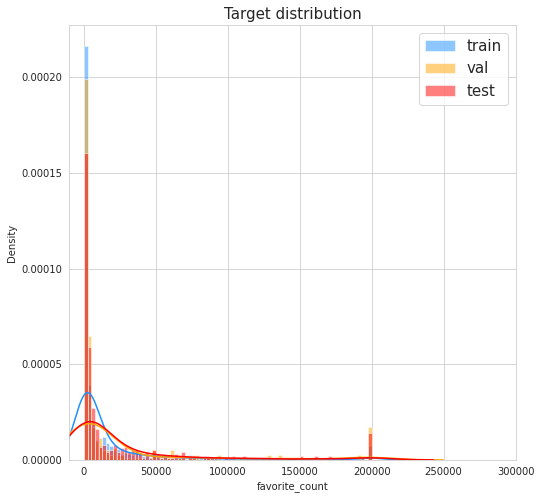

In [10]:
plt.title(f'Target distribution', fontsize=15);
sns.distplot(df_train['favorite_count'].clip(upper=2*1e5), color='dodgerblue', hist_kws={'alpha': 0.5}, label='train', bins=80);
sns.distplot(df_val['favorite_count'].clip(upper=2*1e5), color='orange', hist_kws={'alpha': 0.5}, label='val', bins=80);
sns.distplot(df_test['favorite_count'].clip(upper=2*1e5), color='red', hist_kws={'alpha': 0.5}, label='test', bins=80);
plt.xlim(-10_000, 3*1e5);
plt.legend(fontsize=15);

<a id ='TrainingCatboost'></a>
### Training Catboost
[back to contents](#home)

<a id ='RMSEloss'></a>
#### RMSE loss
[back to contents](#home)

In [12]:
from catboost import CatBoostRegressor

In [13]:
params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.03,
    'objective': 'RMSE',
    'eval_metric': 'RMSE',
    'boost_from_average': False,
    'task_type': "CPU",
    'verbose': 100,
    'random_seed': 42,
}

basic_model = CatBoostRegressor(**params)
basic_model.fit(
    df_train.drop(['created_at', 'favorite_count'], axis=1), 
    df_train['favorite_count'].values,
    eval_set=[(df_val.drop(['created_at', 'favorite_count'], axis=1), df_val['favorite_count'].values)]
)

0:	learn: 56934.8772998	test: 97630.3040285	best: 97630.3040285 (0)	total: 56.5ms	remaining: 9m 25s
100:	learn: 38764.8892333	test: 72734.4815915	best: 72734.4815915 (100)	total: 888ms	remaining: 1m 27s
200:	learn: 36462.7885142	test: 72033.3914921	best: 72012.5376907 (182)	total: 1.71s	remaining: 1m 23s
300:	learn: 34668.1644988	test: 71734.7200291	best: 71729.0729165 (294)	total: 2.54s	remaining: 1m 21s
400:	learn: 32982.2414793	test: 71387.5433704	best: 71271.7242276 (355)	total: 3.39s	remaining: 1m 21s
500:	learn: 31688.1646931	test: 71976.8142902	best: 71271.7242276 (355)	total: 4.22s	remaining: 1m 19s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 71271.72423
bestIteration = 355

Shrink model to first 356 iterations.


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_predictions = basic_model.predict(df_train.drop(['created_at', 'favorite_count'], axis=1))
val_predictions = basic_model.predict(df_val.drop(['created_at', 'favorite_count'], axis=1))
test_predictions = basic_model.predict(df_test.drop(['created_at', 'favorite_count'], axis=1))

train_rmse = np.power(mean_squared_error(y_true=df_train['favorite_count'].values, y_pred=train_predictions), 0.5)
val_rmse = np.power(mean_squared_error(y_true=df_val['favorite_count'].values, y_pred=val_predictions), 0.5)
test_rmse = np.power(mean_squared_error(y_true=df_test['favorite_count'].values, y_pred=test_predictions), 0.5)

train_mae = mean_absolute_error(y_true=df_train['favorite_count'].values, y_pred=train_predictions)
val_mae = mean_absolute_error(y_true=df_val['favorite_count'].values, y_pred=val_predictions)
test_mae = mean_absolute_error(y_true=df_test['favorite_count'].values, y_pred=test_predictions)

print("RMSE:")
print(f"\ttrain: {round(train_rmse, 2):,}")
print(f"\tval: {round(val_rmse, 2):,}")
print(f"\ttest: {round(test_rmse, 2):,}")
print("MAE:")
print(f"\ttrain: {round(train_mae, 2):,}")
print(f"\tval: {round(val_mae, 2):,}")
print(f"\ttest: {round(test_mae, 2):,}")

RMSE:
	train: 33,616.06
	val: 71,271.72
	test: 91,650.72
MAE:
	train: 13,480.3
	val: 31,191.57
	test: 35,225.26


<a id ='CustomRMSEloss'></a>
#### Custom RMSE loss
[back to contents](#home)

In [185]:
class CustomRmseObjective(object):
    
    def calc_ders_range(self, approxes, targets, weights=None):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
            
        grad = (targets - approxes) * (weights or 1)
        hess = -np.ones_like(targets) * (weights or 1)
        
        result = np.hstack((
            grad.reshape(-1, 1),
            hess.reshape(-1, 1)
        ))
        return result
    
class CustomRmseMetric(object):
    
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight=None):
        
        weight = np.ones_like(target) if weight is None else weight
        error_sum = np.sqrt(
            np.sum(weight * (target - approxes)**2) / np.sum(weight)
        )
        return error_sum, np.sum(weight)

In [186]:
params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.03,
    'objective': CustomRmseObjective(),
    'eval_metric': CustomRmseMetric(),
    'boost_from_average': False,
    'task_type': "CPU",
    'verbose': 100,
    'random_seed': 42,
}

custom_rmse_model = CatBoostRegressor(**params)
custom_rmse_model.fit(
    df_train.drop(['created_at', 'favorite_count'], axis=1), 
    df_train['favorite_count'].values,
    eval_set=[(df_val.drop(['created_at', 'favorite_count'], axis=1), df_val['favorite_count'].values)]
)

0:	learn: 56934.8772998	test: 97630.3040285	best: 97630.3040285 (0)	total: 702ms	remaining: 1h 57m 1s
100:	learn: 38764.8892333	test: 72734.4815915	best: 72734.4815915 (100)	total: 1.59s	remaining: 2m 35s
200:	learn: 36462.7885142	test: 72033.3914921	best: 72012.5376907 (182)	total: 2.48s	remaining: 2m
300:	learn: 34668.1644988	test: 71734.7200291	best: 71729.0729165 (294)	total: 3.35s	remaining: 1m 47s
400:	learn: 32982.2414793	test: 71387.5433704	best: 71271.7242276 (355)	total: 4.23s	remaining: 1m 41s
500:	learn: 31688.1646931	test: 71976.8142902	best: 71271.7242276 (355)	total: 5.13s	remaining: 1m 37s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 71271.72423
bestIteration = 355

Shrink model to first 356 iterations.


<a id ='Poissonloss'></a>
#### Poisson loss
[back to contents](#home)

In [15]:
from catboost import CatBoostRegressor

In [16]:
params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.1,
    'objective': 'Poisson',
    'eval_metric': 'RMSE',
    'boost_from_average': False,
    'task_type': "GPU",
    'verbose': 100,
    'random_seed': 42,
}

poisson_model = CatBoostRegressor(**params)
poisson_model.fit(
    df_train.drop(['created_at', 'favorite_count'], axis=1), 
    df_train['favorite_count'].values,
    eval_set=[(df_val.drop(['created_at', 'favorite_count'], axis=1), df_val['favorite_count'].values)]
)

0:	learn: 57615.5465654	test: 98330.9735251	best: 98330.9735251 (0)	total: 72.8ms	remaining: 12m 7s
100:	learn: 57612.0102347	test: 98327.3512638	best: 98327.3512638 (96)	total: 3.23s	remaining: 5m 16s
200:	learn: 57611.9933744	test: 98327.3222852	best: 98327.3222852 (199)	total: 6.19s	remaining: 5m 1s
300:	learn: 57611.9786217	test: 98327.3264250	best: 98327.3098658 (244)	total: 9.16s	remaining: 4m 55s
400:	learn: 57611.9722991	test: 98327.3305648	best: 98327.3098658 (244)	total: 12.2s	remaining: 4m 50s
bestTest = 98327.30987
bestIteration = 244
Shrink model to first 245 iterations.


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_predictions = poisson_model.predict(df_train.drop(['created_at', 'favorite_count'], axis=1))
val_predictions = poisson_model.predict(df_val.drop(['created_at', 'favorite_count'], axis=1))
test_predictions = poisson_model.predict(df_test.drop(['created_at', 'favorite_count'], axis=1))

train_rmse = np.power(mean_squared_error(y_true=df_train['favorite_count'].values, y_pred=train_predictions), 0.5)
val_rmse = np.power(mean_squared_error(y_true=df_val['favorite_count'].values, y_pred=val_predictions), 0.5)
test_rmse = np.power(mean_squared_error(y_true=df_test['favorite_count'].values, y_pred=test_predictions), 0.5)

train_mae = mean_absolute_error(y_true=df_train['favorite_count'].values, y_pred=train_predictions)
val_mae = mean_absolute_error(y_true=df_val['favorite_count'].values, y_pred=val_predictions)
test_mae = mean_absolute_error(y_true=df_test['favorite_count'].values, y_pred=test_predictions)

print("RMSE:")
print(f"\ttrain: {round(train_rmse, 2):,}")
print(f"\tval: {round(val_rmse, 2):,}")
print(f"\ttest: {round(test_rmse, 2):,}")
print("MAE:")
print(f"\ttrain: {round(train_mae, 2):,}")
print(f"\tval: {round(val_mae, 2):,}")
print(f"\ttest: {round(test_mae, 2):,}")

RMSE:
	train: 30,557.53
	val: 75,189.05
	test: 89,887.03
MAE:
	train: 11,117.63
	val: 27,295.54
	test: 27,121.67


<a id ='CustomPoissonloss'></a>
#### Custom Poisson loss
[back to contents](#home)

In [28]:
from math import exp

class CustomPoissonObjective(object):
    
    def calc_ders_range(self, approxes, targets, weights):
        """
        loss = ∑_i w_i * (e^pred_i - pred_i*target_i) / ∑_i w_i
        
        antigrad_i = -grad_i = - w_i * (e^pred_i - target_i)
        
        antihess_i = ∂/∂pred_i (antigrad_i) = -w_i * e^pred_i
        """
            
#         exp_preds = np.exp(approxes)
        
#         antigrad = -(exp_preds - targets) * (weights or 1)
#         hess = -exp_preds * (weights or 1)
        
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            der1 = (targets[index] - approxes[index])
            der2 = -1

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        
        return result

In [29]:
params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.1,
    'objective': CustomPoissonObjective(),
    'eval_metric': 'RMSE',
    'boost_from_average': False,
    'bootstrap_type': 'No',
    'task_type': "CPU",
    'verbose': 100,
    'random_seed': 42,
}

custom_poisson_model = CatBoostRegressor(**params)
custom_poisson_model.fit(
    df_train.drop(['created_at', 'favorite_count'], axis=1), 
    df_train['favorite_count'].values,
    eval_set=[(df_val.drop(['created_at', 'favorite_count'], axis=1), df_val['favorite_count'].values)]
)

0:	learn: 55620.7475130	test: 96183.5896912	best: 96183.5896912 (0)	total: 151ms	remaining: 25m 12s
100:	learn: 33680.6772821	test: 70872.0146462	best: 70832.3015416 (96)	total: 1.03s	remaining: 1m 41s
200:	learn: 29421.3557137	test: 70062.2799382	best: 69852.8108160 (167)	total: 1.94s	remaining: 1m 34s
300:	learn: 24989.5053059	test: 70458.7803202	best: 69852.8108160 (167)	total: 2.83s	remaining: 1m 31s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 69852.81082
bestIteration = 167

Shrink model to first 168 iterations.


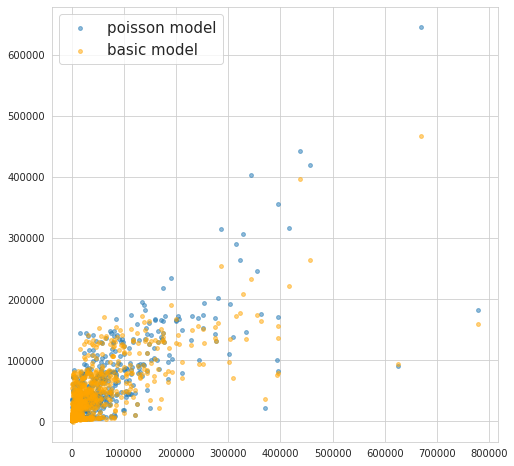

In [77]:
plt.scatter(
    df_train['favorite_count'].values,
    poisson_model.predict(df_train.drop(['created_at', 'favorite_count'], axis=1)),
    alpha=0.5,
    s=15,
    label='poisson model'
)
plt.scatter(
    df_train['favorite_count'].values,
    basic_model.predict(df_train.drop(['created_at', 'favorite_count'], axis=1)),
    alpha=0.5,
    s=15,
    color='orange',
    label='basic model'
)
plt.legend(fontsize=15);

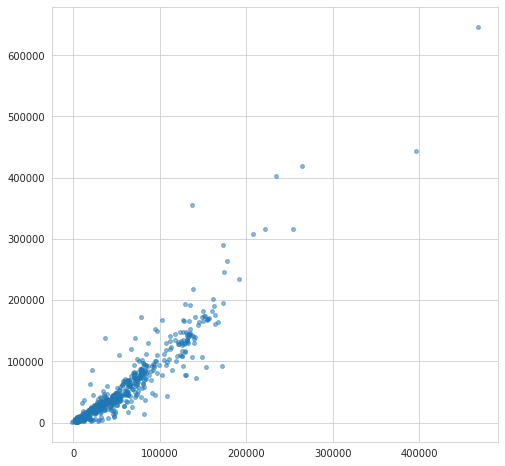

In [78]:
plt.scatter(
    basic_model.predict(df_train.drop(['created_at', 'favorite_count'], axis=1)),
    poisson_model.predict(df_train.drop(['created_at', 'favorite_count'], axis=1)),
    alpha=0.5,
    s=15,
)

<a id='Focallossexample'></a>
### Focal loss example
[back to contents](#home)

In [18]:
from catboost import CatBoostClassifier

In [19]:
df = pd.read_csv('/content/drive/MyDrive/Data/focal_loss_demo/creditcard.csv')
print(f"df: {df.shape[0]:,} x {df.shape[1]:,}")
df.head()

df: 284,807 x 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


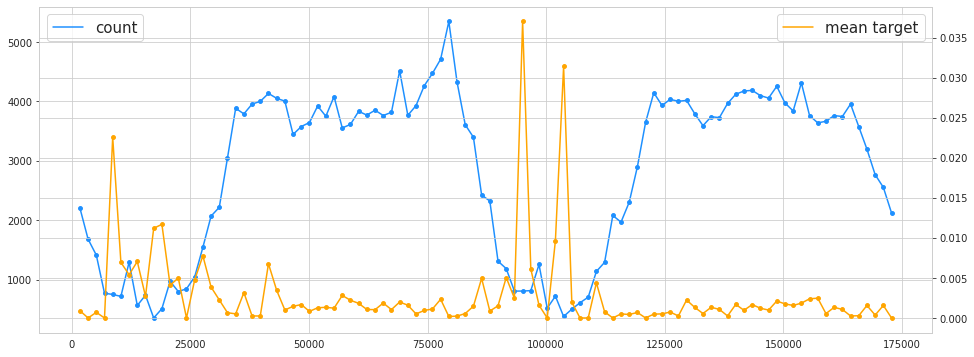

In [23]:
df['time_bins'] = pd.cut(df['Time'], bins=100).apply(lambda x: x.right).astype(float)
tmp = (
    df
    .groupby(['time_bins'])
    .agg(
        mean_target = pd.NamedAgg(column='Class', aggfunc=np.mean),
        cnt = pd.NamedAgg(column='Class', aggfunc=len)
    )
    .reset_index()
    .sort_values(by=['time_bins'], ascending=True)
)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    tmp['time_bins'],
    tmp['cnt'],
    color='dodgerblue',
    label='count'
)
ax.scatter(
    tmp['time_bins'],
    tmp['cnt'],
    color='dodgerblue',
    s=15,
)
ax.legend(fontsize=15, loc='upper left');
ax2 = ax.twinx()
ax2.plot(
    tmp['time_bins'],
    tmp['mean_target'],
    color='orange',
    label='mean target'
)
ax2.scatter(
    tmp['time_bins'],
    tmp['mean_target'],
    color='orange',
    s=15
)
ax2.legend(fontsize=15, loc='upper right');

In [24]:
df = df.loc[
    (
        (df['time_bins'] >= 35_000) &
        (df['time_bins'] <= 80_000) 
    ) |
    (
        (df['time_bins'] >= 122_000)
    ) 
].reset_index(drop=True)
print(f"df: {df.shape[0]:,} x {df.shape[1]:,}")

df: 216,278 x 32


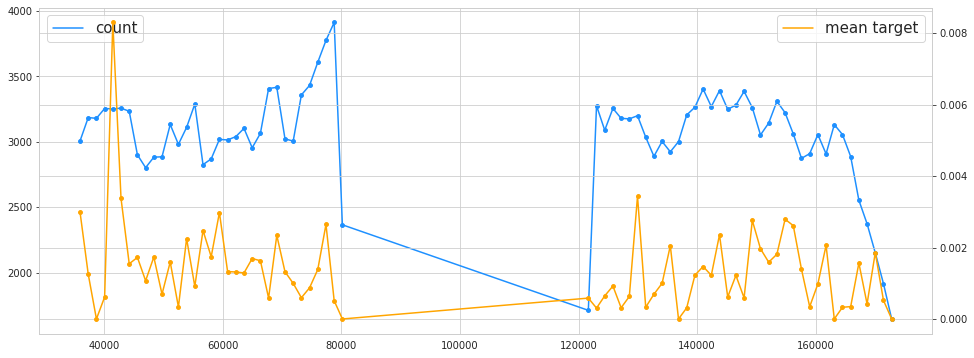

In [25]:
df['time_bins'] = pd.cut(df['Time'], bins=100).apply(lambda x: x.right).astype(float)
tmp = (
    df
    .groupby(['time_bins'])
    .agg(
        mean_target = pd.NamedAgg(column='Class', aggfunc=np.mean),
        cnt = pd.NamedAgg(column='Class', aggfunc=len)
    )
    .reset_index()
    .sort_values(by=['time_bins'], ascending=True)
)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    tmp['time_bins'],
    tmp['cnt'],
    color='dodgerblue',
    label='count'
)
ax.scatter(
    tmp['time_bins'],
    tmp['cnt'],
    color='dodgerblue',
    s=15,
)
ax.legend(fontsize=15, loc='upper left');
ax2 = ax.twinx()
ax2.plot(
    tmp['time_bins'],
    tmp['mean_target'],
    color='orange',
    label='mean target'
)
ax2.scatter(
    tmp['time_bins'],
    tmp['mean_target'],
    color='orange',
    s=15
)
ax2.legend(fontsize=15, loc='upper right');

In [26]:
X_tr = df.loc[(df['time_bins'] <= 75_000)].reset_index(drop=True)
y_tr = X_tr['Class'].values
X_tr.drop(['Class'], axis=1, inplace=True)

X_val = df.loc[(df['time_bins'] > 75_000) & (df['time_bins'] <= 142_000)].reset_index(drop=True)
y_val = X_val['Class'].values
X_val.drop(['Class'], axis=1, inplace=True)

X_te = df.loc[(df['time_bins'] > 142_000)].reset_index(drop=True)
y_te = X_te['Class'].values
X_te.drop(['Class'], axis=1, inplace=True)

print(f"train: {X_tr.shape[0]:,} x {X_tr.shape[1]:,}")
print(f"\t0: {np.sum(y_tr == 0)} ({round(np.sum(y_tr == 0)/len(y_tr)*100, 2)}%)")
print(f"\t1: {np.sum(y_tr == 1)} ({round(np.sum(y_tr == 1)/len(y_tr)*100, 2)}%)", end='\n'*2)
print(f"val: {X_val.shape[0]:,} x {X_val.shape[1]:,}")
print(f"\t0: {np.sum(y_val == 0)} ({round(np.sum(y_val == 0)/len(y_val)*100, 2)}%)")
print(f"\t1: {np.sum(y_val == 1)} ({round(np.sum(y_val == 1)/len(y_val)*100, 2)}%)", end='\n'*2)
print(f"test: {X_te.shape[0]:,} x {X_te.shape[1]:,}")
print(f"\t0: {np.sum(y_te == 0)} ({round(np.sum(y_te == 0)/len(y_te)*100, 2)}%)")
print(f"\t1: {np.sum(y_te == 1)} ({round(np.sum(y_te == 1)/len(y_te)*100, 2)}%)", end='\n'*2)

train: 89,897 x 31
	0: 89743 (99.83%)
	1: 154 (0.17%)

val: 59,284 x 31
	0: 59224 (99.9%)
	1: 60 (0.1%)

test: 67,097 x 31
	0: 67008 (99.87%)
	1: 89 (0.13%)



In [27]:
feature_columns = np.array([
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6",
    "V7",
    "V8",
    "V9",
    "V10",
    "V11",
    "V12",
    "V13",
    "V14",
    "V15",
    "V16",
    "V17",
    "V18",
    "V19",
    "V20",
    "V21",
    "V22",
    "V23",
    "V24",
    "V25",
    "V26",
    "V27",
    "V28",
    "Amount"
])

In [28]:
params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.1,
    'objective': "Logloss",
    'eval_metric': 'AUC',
    'boost_from_average': False,
    'task_type': "CPU",
    'verbose': 100,
    'random_seed': 42,
    
    "bootstrap_type": 'Bayesian',
    "leaf_estimation_iterations": 3,
    "leaf_estimation_method": 'Gradient',
}

logloss_model = CatBoostClassifier(**params)
logloss_model.fit(
    X_tr[feature_columns], 
    y_tr,
    eval_set=[(X_val[feature_columns], y_val)]
)

0:	test: 0.7333163	best: 0.7333163 (0)	total: 37.7ms	remaining: 6m 17s
100:	test: 0.9588388	best: 0.9592161 (98)	total: 2.76s	remaining: 4m 30s
200:	test: 0.9631079	best: 0.9631560 (192)	total: 5.26s	remaining: 4m 16s
300:	test: 0.9681326	best: 0.9685840 (293)	total: 7.69s	remaining: 4m 7s
400:	test: 0.9704931	best: 0.9704931 (400)	total: 10.1s	remaining: 4m 2s
500:	test: 0.9698926	best: 0.9709023 (426)	total: 12.6s	remaining: 3m 58s
600:	test: 0.9709239	best: 0.9709749 (577)	total: 15.1s	remaining: 3m 56s
700:	test: 0.9718864	best: 0.9719444 (689)	total: 17.6s	remaining: 3m 53s
800:	test: 0.9709819	best: 0.9720673 (750)	total: 20.1s	remaining: 3m 51s
900:	test: 0.9719683	best: 0.9721734 (853)	total: 22.6s	remaining: 3m 47s
1000:	test: 0.9717750	best: 0.9721734 (853)	total: 25.1s	remaining: 3m 45s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9721734432
bestIteration = 853

Shrink model to first 854 iterations.


In [29]:
from scipy.special import expit

class CustomLoglossObjective(object):
    """
    L(y, z) = -y*log(sigma(z)) - (1 - y)*log(1 - sigma(z))
    """
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
            
        after_sigmoid = expit(approxes)
            
        antigrad = (targets - after_sigmoid) * (weights or 1)
        hess = -after_sigmoid * (1 - after_sigmoid) * (weights or 1)
        
        result = np.hstack((
            antigrad.reshape(-1, 1),
            hess.reshape(-1, 1)
        ))
        return result

In [30]:
params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.1,
    'objective': CustomLoglossObjective(),
    'eval_metric': 'AUC',
    'boost_from_average': False,
    'task_type': "CPU",
    'verbose': 100,
    'random_seed': 42,
    
    "bootstrap_type": 'Bayesian',
    "leaf_estimation_iterations": 3,
    "leaf_estimation_method": 'Gradient',
}

custom_logloss_model = CatBoostClassifier(**params)
custom_logloss_model.fit(
    X_tr[feature_columns], 
    y_tr,
    eval_set=[(X_val[feature_columns], y_val)]
)

0:	test: 0.7333163	best: 0.7333163 (0)	total: 343ms	remaining: 57m 9s
100:	test: 0.9588388	best: 0.9592161 (98)	total: 9.54s	remaining: 15m 34s
200:	test: 0.9631079	best: 0.9631560 (192)	total: 18.5s	remaining: 15m 3s
300:	test: 0.9681326	best: 0.9685840 (293)	total: 27.7s	remaining: 14m 53s
400:	test: 0.9704931	best: 0.9704931 (400)	total: 36.8s	remaining: 14m 39s
500:	test: 0.9698926	best: 0.9709023 (426)	total: 45.9s	remaining: 14m 30s
600:	test: 0.9709239	best: 0.9709749 (577)	total: 54.9s	remaining: 14m 19s
700:	test: 0.9718864	best: 0.9719444 (689)	total: 1m 4s	remaining: 14m 12s
800:	test: 0.9709819	best: 0.9720673 (750)	total: 1m 13s	remaining: 14m 4s
900:	test: 0.9719683	best: 0.9721734 (853)	total: 1m 22s	remaining: 13m 51s
1000:	test: 0.9717750	best: 0.9721734 (853)	total: 1m 31s	remaining: 13m 41s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9721734432
bestIteration = 853

Shrink model to first 854 iterations.


In [31]:
from sklearn.metrics import roc_auc_score

train_predictions = custom_logloss_model.predict_proba(X_tr[feature_columns])[:, 1]
val_predictions = custom_logloss_model.predict_proba(X_val[feature_columns])[:, 1]
test_predictions = custom_logloss_model.predict_proba(X_te[feature_columns])[:, 1]

train_auc = roc_auc_score(
    y_true=y_tr,
    y_score=train_predictions
)
val_auc = roc_auc_score(
    y_true=y_val,
    y_score=val_predictions
)
test_auc = roc_auc_score(
    y_true=y_te,
    y_score=test_predictions
)

print("AUC-ROC:")
print(f"\ttrain: {round(train_auc, 4):,}")
print(f"\tval: {round(val_auc, 4):,}")
print(f"\ttest: {round(test_auc, 4):,}")

AUC-ROC:
	train: 1.0
	val: 0.9722
	test: 0.9695


In [32]:
import math
from scipy.special import expit

class FocalLossObjective(object):
    
    def __init__(self, gamma: float=2.0, alpha: float=1.0):
        self.gamma = gamma
        self.alpha = alpha
    
    def calc_ders_range(self, approxes, targets, weights):
        gamma = self.gamma
        alpha = self.alpha
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

#         exponents = np.exp(approxes)
#         p = exponents / (1 + exponents)
        p = expit(approxes)
        p_y = p * (targets > 0) + (1 - p) * (targets <= 0)
        a_y = alpha * (targets > 0) + (1 - alpha) * (targets <= 0)
        
    
        antigrad = (
            -(2*targets - 1)*((1-p_y)**(gamma))*(gamma * np.log(p_y) * p_y + p_y - 1)
        ) * (weights or 1)
        
        antihess = (
            -(2*targets - 1) * (
                 gamma * (1 - p_y)**(gamma-1) * (gamma * np.log(p_y) * p_y + p_y - 1)
                + 
                 (1 - p_y)**gamma * (gamma * (1 + np.log(p_y)) + 1)
            ) * (weights or 1)
        )

        result = np.hstack((
            antigrad.reshape(-1, 1),
            antihess.reshape(-1, 1)
        ))
        
        return result


In [33]:
%%time
params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.1,
    'objective': FocalLossObjective(gamma=2.0),
    'eval_metric': 'AUC',
    'boost_from_average': False,
    'task_type': "CPU",
    'verbose': 100,
    'random_seed': 42,
    
    "bootstrap_type": 'Bayesian',
    "leaf_estimation_iterations": 3,
    "leaf_estimation_method": 'Gradient',
}

custom_flloss_model = CatBoostClassifier(**params)
custom_flloss_model.fit(
    X_tr[feature_columns], 
    y_tr,
    eval_set=[(X_val[feature_columns], y_val)]
)

0:	test: 0.7320246	best: 0.7320246 (0)	total: 213ms	remaining: 35m 25s
100:	test: 0.9606547	best: 0.9606547 (100)	total: 21.8s	remaining: 35m 35s
200:	test: 0.9702722	best: 0.9705232 (196)	total: 43.1s	remaining: 35m 2s
300:	test: 0.9747464	best: 0.9750810 (279)	total: 1m 3s	remaining: 34m 16s
400:	test: 0.9748151	best: 0.9766590 (366)	total: 1m 25s	remaining: 34m 7s
500:	test: 0.9734342	best: 0.9766590 (366)	total: 1m 46s	remaining: 33m 44s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9766589558
bestIteration = 366

Shrink model to first 367 iterations.
CPU times: user 2min 13s, sys: 37.8 s, total: 2min 51s
Wall time: 2min 1s


In [34]:
from sklearn.metrics import roc_auc_score

train_predictions = custom_flloss_model.predict_proba(X_tr[feature_columns])[:, 1]
val_predictions = custom_flloss_model.predict_proba(X_val[feature_columns])[:, 1]
test_predictions = custom_flloss_model.predict_proba(X_te[feature_columns])[:, 1]

train_auc = roc_auc_score(
    y_true=y_tr,
    y_score=train_predictions
)
val_auc = roc_auc_score(
    y_true=y_val,
    y_score=val_predictions
)
test_auc = roc_auc_score(
    y_true=y_te,
    y_score=test_predictions
)

print("AUC-ROC:")
print(f"\ttrain: {round(train_auc, 4):,}")
print(f"\tval: {round(val_auc, 4):,}")
print(f"\ttest: {round(test_auc, 4):,}")

AUC-ROC:
	train: 1.0
	val: 0.9767
	test: 0.9726


<a id='Tweedieloss'></a>
### Tweedie loss
[back to contents](#home)

In [5]:
from IPython.display import display

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Data/tweedie_data_demo/claims.csv')
print(f'df: {df.shape[0]:,} x {df.shape[1]:,}')
df.head(3)

df: 678,013 x 12


,id_pol,claim_nb,exposure,area,veh_power,veh_age,drive_age,bonus_malus,veh_brand,veh_gas,density,region
0,1.0,1,0.10,'D',5,0,55,50,'B12','Regular',1217,'R82'
1,3.0,1,0.77,'D',5,0,55,50,'B12','Regular',1217,'R82'
2,5.0,1,0.75,'B',6,2,52,50,'B12','Diesel',54,'R22'


0     643,953
1      32,178
2       1,784
3          82
4           7
5           2
6           1
8           1
9           1
11          3
16          1
Name: claim_nb, dtype: object

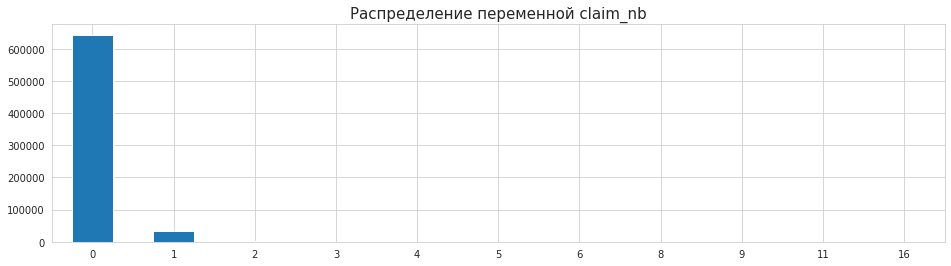

In [7]:
display(df['claim_nb'].value_counts().sort_index().apply(lambda x: f"{x:,}"))
plt.title(f'Распределение переменной claim_nb', fontsize=15);
df['claim_nb'].value_counts().sort_index().plot(kind='bar', figsize=(16, 4))
plt.tick_params(axis='x', rotation=0);

In [8]:
df = df.loc[(df['claim_nb'] <= 3)].reset_index(drop=True)
print(f"{df.shape[0]:,}")

677,997


In [9]:
def print_statistic(target_col: pd.Series, df_name: str='train', offset: int=10):
    df_len = len(target_col)
    print_str = ''
    print_str += f'{df_name} ({target_col.shape[0]:,}):\n'
    for k, v in target_col.value_counts().sort_index().items():
        print_str += f'\t{k}' + ' '+'-'*(offset - len(str(k)))+' ' + f'{v:,} ({round(v*100/df_len, 2)}%)\n'
    print(print_str)

In [10]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    df.drop(['id_pol', 'claim_nb'], axis=1),
    df['claim_nb'].values,
    stratify=df['claim_nb'].values,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr,
    y_tr,
    stratify=y_tr,
    test_size=0.3,
    shuffle=True,
    random_state=42,
)
print_statistic(target_col=pd.Series(y_tr), df_name='train', offset=5)
print()
print_statistic(target_col=pd.Series(y_val), df_name='val', offset=5)
print()
print_statistic(target_col=pd.Series(y_te), df_name='test', offset=5)
print()

train (379,677):
	0 ---- 360,613 (94.98%)
	1 ---- 18,019 (4.75%)
	2 ---- 999 (0.26%)
	3 ---- 46 (0.01%)


val (162,720):
	0 ---- 154,549 (94.98%)
	1 ---- 7,723 (4.75%)
	2 ---- 428 (0.26%)
	3 ---- 20 (0.01%)


test (135,600):
	0 ---- 128,791 (94.98%)
	1 ---- 6,436 (4.75%)
	2 ---- 357 (0.26%)
	3 ---- 16 (0.01%)




In [11]:
cat_features = ['area', 'veh_brand', 'veh_gas', 'region']

In [12]:
%%time
from catboost import CatBoostRegressor

params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.1,
    'objective': 'RMSE',
    'eval_metric': 'RMSE',
    'boost_from_average': False,
    'task_type': "GPU",
    'verbose': 100,
    'random_seed': 42,
    
#     "bootstrap_type": 'Bayesian',
#     "leaf_estimation_iterations": 3,
#     "leaf_estimation_method": 'Gradient',
}

base_model = CatBoostRegressor(**params)
base_model.fit(
    X_tr, 
    y_tr,
    eval_set=[(X_val, y_val)],
    cat_features=cat_features
)

0:	learn: 0.2414617	test: 0.2415202	best: 0.2415202 (0)	total: 35.5ms	remaining: 5m 54s
100:	learn: 0.2322259	test: 0.2329624	best: 0.2329624 (100)	total: 2.54s	remaining: 4m 8s
200:	learn: 0.2315029	test: 0.2326984	best: 0.2326984 (200)	total: 4.92s	remaining: 3m 59s
300:	learn: 0.2310078	test: 0.2326203	best: 0.2326194 (299)	total: 7.34s	remaining: 3m 56s
400:	learn: 0.2305387	test: 0.2325476	best: 0.2325390 (393)	total: 9.73s	remaining: 3m 53s
500:	learn: 0.2301904	test: 0.2325290	best: 0.2325245 (487)	total: 12.1s	remaining: 3m 49s
600:	learn: 0.2298048	test: 0.2325214	best: 0.2325172 (594)	total: 14.6s	remaining: 3m 47s
700:	learn: 0.2294737	test: 0.2325019	best: 0.2324908 (665)	total: 17s	remaining: 3m 45s
800:	learn: 0.2291464	test: 0.2325122	best: 0.2324906 (709)	total: 19.4s	remaining: 3m 42s
900:	learn: 0.2288549	test: 0.2325128	best: 0.2324906 (709)	total: 21.9s	remaining: 3m 40s
bestTest = 0.2324906453
bestIteration = 709
Shrink model to first 710 iterations.
CPU times: use

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_predictions = base_model.predict(X_tr)
val_predictions = base_model.predict(X_val)
test_predictions = base_model.predict(X_te)

train_rmse = np.power(mean_squared_error(y_true=y_tr, y_pred=train_predictions), 0.5)
val_rmse = np.power(mean_squared_error(y_true=y_val, y_pred=val_predictions), 0.5)
test_rmse = np.power(mean_squared_error(y_true=y_te, y_pred=test_predictions), 0.5)

train_mae = mean_absolute_error(y_true=y_tr, y_pred=train_predictions)
val_mae = mean_absolute_error(y_true=y_val, y_pred=val_predictions)
test_mae = mean_absolute_error(y_true=y_te, y_pred=test_predictions)

print("RMSE:")
print(f"\ttrain: {round(train_rmse, 2):,}")
print(f"\tval: {round(val_rmse, 2):,}")
print(f"\ttest: {round(test_rmse, 2):,}")
print("MAE:")
print(f"\ttrain: {round(train_mae, 2):,}")
print(f"\tval: {round(val_mae, 2):,}")
print(f"\ttest: {round(test_mae, 2):,}")

RMSE:
	train: 0.23
	val: 0.23
	test: 0.23
MAE:
	train: 0.1
	val: 0.1
	test: 0.1


In [19]:
%%time
from catboost import CatBoostRegressor

params = {
    'n_estimators': 10_000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.1,
    'objective': 'Tweedie:variance_power=1.9',
    'eval_metric': 'RMSE',
    'boost_from_average': False,
    'task_type': "GPU",
    'verbose': 100,
    'random_seed': 42,
    
#     "bootstrap_type": 'Bayesian',
#     "leaf_estimation_iterations": 3,
#     "leaf_estimation_method": 'Gradient',
}

tweedie_model = CatBoostRegressor(**params)
tweedie_model.fit(
    X_tr, 
    y_tr,
    eval_set=[(X_val, y_val)],
    cat_features=cat_features
)

0:	learn: 0.2430513	test: 0.2430854	best: 0.2430854 (0)	total: 34.1ms	remaining: 5m 40s
100:	learn: 0.2430510	test: 0.2430915	best: 0.2430851 (40)	total: 2.15s	remaining: 3m 30s
200:	learn: 0.2430540	test: 0.2431175	best: 0.2430851 (40)	total: 4.37s	remaining: 3m 33s
bestTest = 0.2430850907
bestIteration = 40
Shrink model to first 41 iterations.
CPU times: user 7.44 s, sys: 1.24 s, total: 8.68 s
Wall time: 6.67 s


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_predictions = tweedie_model.predict(X_tr)
val_predictions = tweedie_model.predict(X_val)
test_predictions = tweedie_model.predict(X_te)

train_rmse = np.power(mean_squared_error(y_true=y_tr, y_pred=train_predictions), 0.5)
val_rmse = np.power(mean_squared_error(y_true=y_val, y_pred=val_predictions), 0.5)
test_rmse = np.power(mean_squared_error(y_true=y_te, y_pred=test_predictions), 0.5)

train_mae = mean_absolute_error(y_true=y_tr, y_pred=train_predictions)
val_mae = mean_absolute_error(y_true=y_val, y_pred=val_predictions)
test_mae = mean_absolute_error(y_true=y_te, y_pred=test_predictions)

print("RMSE:")
print(f"\ttrain: {round(train_rmse, 2):,}")
print(f"\tval: {round(val_rmse, 2):,}")
print(f"\ttest: {round(test_rmse, 2):,}")
print("MAE:")
print(f"\ttrain: {round(train_mae, 2):,}")
print(f"\tval: {round(val_mae, 2):,}")
print(f"\ttest: {round(test_mae, 2):,}")

RMSE:
	train: 0.98
	val: 0.98
	test: 0.98
MAE:
	train: 0.95
	val: 0.95
	test: 0.95


<a id='Uncertainty'></a>
### Uncertainty
[back to contents](#home)

In [6]:
import catboost as cb

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/Data/kdd_data/train_data.csv')
train_target = train_df['target'].values
train_df.drop(['target'], axis=1, inplace=True)
print(f"train: {train_df.shape[0]:,} x {train_df.shape[1]:,}")

test_df = pd.read_csv('/content/drive/MyDrive/Data/kdd_data/test_data.csv')
test_target = test_df['target'].values
test_df.drop(['target'], axis=1, inplace=True)
print(f"test: {test_df.shape[0]:,} x {test_df.shape[1]:,}")

ood_df = pd.read_csv('/content/drive/MyDrive/Data/kdd_data/ood_data.csv')
ood_target = ood_df['target'].values
ood_df.drop(['target'], axis=1, inplace=True)
print(f"ood: {ood_df.shape[0]:,} x {ood_df.shape[1]:,}")


train: 1,074,992 x 42
test: 73,269 x 42
ood: 4,022 x 42


In [8]:
train_pool = cb.Pool(
    data=train_df.drop(['counts'], axis=1),
    label=train_target,
    weight=train_df['counts'].values,
    cat_features=[1, 2, 3, 6, 11, 20, 21],
)

test_pool = cb.Pool(
    data=test_df.drop(['counts'], axis=1),
    label=test_target,
    weight=test_df['counts'].values,
    cat_features=[1, 2, 3, 6, 11, 20, 21],
)

ood_pool = cb.Pool(
    data=ood_df.drop(['counts'], axis=1),
    label=ood_target,
    weight=ood_df['counts'].values,
    cat_features=[1, 2, 3, 6, 11, 20, 21],
)

In [9]:
# import context
from catboost import CatBoostClassifier


class ClassificationEnsemble(object):

    def __init__(self, esize=10, iterations=1000, lr=0.1, random_strength=None, border_count=None, depth=6, seed=100,
                 load_path=None, task_type=None, devices=None, verbose=True, use_base_model=False,
                 max_ctr_complexity=None, posterior_sampling=True):

        self.seed = seed
        self.esize = esize
        self.depth = depth
        self.iterations = iterations
        self.lr = lr
        self.posterior_sampling = posterior_sampling
        if self.posterior_sampling:
            self.bootstrap_type = 'No'
            self.subsample = None
        else:
            self.bootstrap_type = 'Bernoulli'
            self.subsample = 0.5
        self.random_strength = random_strength
        self.border_count = border_count
        self.posterior_sampling = posterior_sampling
        self.ensemble = []
        self.use_best_model = use_base_model
        for e in range(self.esize):
            model = CatBoostClassifier(iterations=self.iterations,
                                       depth=self.depth,
                                       learning_rate=self.lr,
                                       border_count=self.border_count,
                                       random_strength=self.random_strength,
                                       loss_function='MultiClass',
                                       verbose=verbose,
                                       posterior_sampling=self.posterior_sampling,
                                       use_best_model=self.use_best_model,
                                       max_ctr_complexity=max_ctr_complexity,
                                       random_seed=self.seed + e,
                                       subsample=self.subsample,
                                       task_type=task_type,
                                       bootstrap_type=self.bootstrap_type,
                                       devices=devices)
            self.ensemble.append(model)

        if load_path is not None:
            for i, m in enumerate(self.ensemble):
                m.load_model(f"{load_path}/model{i}.cbm")

    def fit(self, data, eval_set=None, save_path="./"):

        for i, m in enumerate(self.ensemble):
            print(f"TRAINING MODEL {i}\n\n")
            m.fit(data, eval_set=eval_set)
            m.save_model(f"{save_path}/model{i}.cbm")
            assert np.all(m.classes_ == self.ensemble[0].classes_)

    def save(self, path):
        for i, m in enumerate(self.ensemble):
            m.save_model(f"{path}/model{i}.cmb")

    def predict(self, x):
        probs = []

        for m in self.ensemble:
            assert np.all(m.classes_ == self.ensemble[0].classes_)
            prob = m.predict_proba(x)
            probs.append(prob)

        probs = np.stack(probs)
        return probs


class ClassificationEnsembleSGLB(ClassificationEnsemble):

    def __init__(self, esize=10, iterations=1000, lr=0.1, random_strength=None, border_count=None, depth=6, seed=100,
                 load_path=None, task_type=None, devices=None, verbose=True, use_base_model=False,
                 max_ctr_complexity=None, n_objects=10000):

        self.seed = seed
        self.esize = esize
        self.depth = depth
        self.iterations = iterations
        self.lr = lr
        self.random_strength = random_strength
        self.border_count = border_count
        self.ensemble = []
        self.use_best_model = use_base_model
        self.n_objects = n_objects
        for e in range(self.esize):
            model = CatBoostClassifier(iterations=self.iterations,
                                       depth=self.depth,
                                       learning_rate=self.lr,
                                       border_count=self.border_count,
                                       random_strength=self.random_strength,
                                       loss_function='MultiClass',
                                       verbose=verbose,
                                       langevin=True,
                                       diffusion_temperature=self.n_objects,
                                       model_shrink_rate=0.5/self.n_objects,
                                       use_best_model=self.use_best_model,
                                       max_ctr_complexity=max_ctr_complexity,
                                       random_seed=self.seed + e,
                                       subsample=None,
                                       task_type=task_type,
                                       bootstrap_type='No',
                                       devices=devices)
            self.ensemble.append(model)

        if load_path is not None:
            for i, m in enumerate(self.ensemble):
                m.load_model(f"{load_path}/model{i}.cbm")

    def fit(self, data, eval_set=None, save_path="./"):

        for i, m in enumerate(self.ensemble):
            print(f"TRAINING MODEL {i}\n\n")
            m.fit(data, eval_set=eval_set)
            m.save_model(f"{save_path}/model{i}.cbm")
            assert np.all(m.classes_ == self.ensemble[0].classes_)

    def save(self, path):
        for i, m in enumerate(self.ensemble):
            m.save_model(f"{path}/model{i}.cmb")

    def predict(self, x):
        probs = []

        for m in self.ensemble:
            assert np.all(m.classes_ == self.ensemble[0].classes_)
            prob = m.predict_proba(x)
            probs.append(prob)

        probs = np.stack(probs)
        return probs

In [9]:
%%time
ens = ClassificationEnsembleSGLB(
    esize=2,
    iterations=100,
    lr=0.15,
    depth=6,
    seed=42,
    verbose=True,
    n_objects=10_000,
    random_strength=None,
    max_ctr_complexity=None,
    task_type=None,
    devices=None
)

ens.fit(train_pool, eval_set=test_pool, save_path='/content/drive/MyDrive/Data/kdd_data/')

TRAINING MODEL 0


0:	learn: 2.0109008	test: 2.0437539	best: 2.0437539 (0)	total: 45.3s	remaining: 1h 14m 46s
1:	learn: 1.0685224	test: 1.1057985	best: 1.1057985 (1)	total: 1m 40s	remaining: 1h 21m 54s
2:	learn: 0.8383595	test: 0.9041039	best: 0.9041039 (2)	total: 3m	remaining: 1h 37m 17s
3:	learn: 0.7445029	test: 0.8160043	best: 0.8160043 (3)	total: 3m 15s	remaining: 1h 18m 22s
4:	learn: 0.6261656	test: 0.7034769	best: 0.7034769 (4)	total: 3m 43s	remaining: 1h 10m 55s
5:	learn: 0.5234783	test: 0.6187260	best: 0.6187260 (5)	total: 5m 6s	remaining: 1h 19m 54s
6:	learn: 0.4516760	test: 0.5525674	best: 0.5525674 (6)	total: 5m 46s	remaining: 1h 16m 49s
7:	learn: 0.4133441	test: 0.5191083	best: 0.5191083 (7)	total: 6m 27s	remaining: 1h 14m 19s
8:	learn: 0.3597993	test: 0.4775061	best: 0.4775061 (8)	total: 7m 21s	remaining: 1h 14m 20s
9:	learn: 0.3289163	test: 0.4441925	best: 0.4441925 (9)	total: 8m 42s	remaining: 1h 18m 23s
10:	learn: 0.2884174	test: 0.4097395	best: 0.4097395 (10)	total: 9m

89:	learn: 0.0017988	test: 0.2192174	best: 0.2164190 (68)	total: 1h 37m 32s	remaining: 10m 50s
90:	learn: 0.0017355	test: 0.2191043	best: 0.2164190 (68)	total: 1h 38m 51s	remaining: 9m 46s
91:	learn: 0.0017052	test: 0.2194381	best: 0.2164190 (68)	total: 1h 40m 10s	remaining: 8m 42s
92:	learn: 0.0016776	test: 0.2183406	best: 0.2164190 (68)	total: 1h 41m 33s	remaining: 7m 38s
93:	learn: 0.0016311	test: 0.2179178	best: 0.2164190 (68)	total: 1h 42m 52s	remaining: 6m 33s
94:	learn: 0.0016013	test: 0.2172741	best: 0.2164190 (68)	total: 1h 44m 11s	remaining: 5m 29s
95:	learn: 0.0015903	test: 0.2172286	best: 0.2164190 (68)	total: 1h 45m 33s	remaining: 4m 23s
96:	learn: 0.0015679	test: 0.2172639	best: 0.2164190 (68)	total: 1h 46m 52s	remaining: 3m 18s
97:	learn: 0.0015545	test: 0.2169616	best: 0.2164190 (68)	total: 1h 48m 11s	remaining: 2m 12s
98:	learn: 0.0015330	test: 0.2169495	best: 0.2164190 (68)	total: 1h 49m 30s	remaining: 1m 6s
99:	learn: 0.0014851	test: 0.2176208	best: 0.2164190 (68)	to

77:	learn: 0.0023159	test: 0.1956139	best: 0.1931860 (64)	total: 1h 23m 47s	remaining: 23m 37s
78:	learn: 0.0022224	test: 0.1955896	best: 0.1931860 (64)	total: 1h 25m 9s	remaining: 22m 38s
79:	learn: 0.0022211	test: 0.1950417	best: 0.1931860 (64)	total: 1h 25m 37s	remaining: 21m 24s
80:	learn: 0.0021966	test: 0.1947631	best: 0.1931860 (64)	total: 1h 26m 57s	remaining: 20m 23s
81:	learn: 0.0021789	test: 0.1957853	best: 0.1931860 (64)	total: 1h 28m 16s	remaining: 19m 22s
82:	learn: 0.0020947	test: 0.1947978	best: 0.1931860 (64)	total: 1h 29m 39s	remaining: 18m 21s
83:	learn: 0.0020651	test: 0.1948818	best: 0.1931860 (64)	total: 1h 31m 2s	remaining: 17m 20s
84:	learn: 0.0019879	test: 0.1947490	best: 0.1931860 (64)	total: 1h 32m 22s	remaining: 16m 18s
85:	learn: 0.0019480	test: 0.1946321	best: 0.1931860 (64)	total: 1h 33m 41s	remaining: 15m 15s
86:	learn: 0.0019316	test: 0.1957022	best: 0.1931860 (64)	total: 1h 35m 4s	remaining: 14m 12s
87:	learn: 0.0019175	test: 0.1967277	best: 0.1931860 

In [10]:
test_df

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var33,var34,var35,var36,var37,var38,var39,var40,var41,counts
0,0,icmp,eco_i,SF,10008,0,0,0,0,0,...,28,0.11,0.02,0.19,0.00,0.0,0.0,0.00,0.00,1.0
1,0,icmp,eco_i,SF,10008,0,0,0,0,0,...,32,0.13,0.02,0.20,0.00,0.0,0.0,0.00,0.00,1.0
2,0,icmp,eco_i,SF,10008,0,0,0,0,0,...,36,0.14,0.02,0.22,0.00,0.0,0.0,0.00,0.00,1.0
3,0,icmp,eco_i,SF,18,0,0,0,0,0,...,10,1.00,0.00,1.00,1.00,0.0,0.0,0.00,0.00,1.0
4,0,icmp,eco_i,SF,18,0,0,0,0,0,...,102,1.00,0.00,1.00,1.00,0.0,0.0,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73264,9,tcp,smtp,SF,1868,323,0,0,0,0,...,176,0.75,0.02,0.01,0.01,0.0,0.0,0.00,0.00,1.0
73265,9,tcp,smtp,SF,2113,334,0,0,0,0,...,154,0.60,0.02,0.00,0.00,0.0,0.0,0.00,0.00,1.0
73266,9,tcp,smtp,SF,2166,327,0,0,0,0,...,116,0.49,0.02,0.00,0.00,0.0,0.0,0.00,0.00,1.0
73267,9,tcp,smtp,SF,23651,328,0,0,0,0,...,193,0.92,0.05,0.02,0.01,0.0,0.0,0.00,0.00,1.0


In [11]:
ens = ClassificationEnsembleSGLB(
    esize=2,
    verbose=True,
    load_path='/content/drive/MyDrive/Data/kdd_data/'
)

In [48]:
class_map = {}
for i, c in enumerate(ens.ensemble[0].classes_):
    class_map[c] = i

test_labels = [class_map[l] for l in test_pool.get_label()]

In [49]:
from scipy.special import softmax
#for m in range(args.n_models):
id_probs = ens.ensemble[0].virtual_ensembles_predict(
    test_pool, 
    prediction_type='VirtEnsembles', 
    virtual_ensembles_count=2
)
id_probs = softmax(id_probs, axis=2).transpose([1,0,2])
ood_probs = ens.ensemble[0].virtual_ensembles_predict(
    ood_pool, 
    prediction_type='VirtEnsembles',
    virtual_ensembles_count=2
)
ood_probs = softmax(ood_probs, axis=2).transpose([1,0,2])
# MUST GET SOFTMAX
print(id_probs.shape, ood_probs.shape)

(2, 73269, 23) (2, 4022, 23)


In [50]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score

def entropy(probs, epsilon=1e-10):
    log_probs = -np.log(probs + epsilon)
    return np.sum(probs * log_probs, axis=1)


def ood_detect(domain_labels, in_measure, out_measure, mode, pos_label=1):
    scores = np.concatenate((in_measure, out_measure), axis=0)
    scores = np.asarray(scores, dtype=np.float128)
    if pos_label != 1:
        scores *= -1.0

    if mode == 'PR':
        precision, recall, thresholds = precision_recall_curve(domain_labels, scores)
        aupr = auc(recall, precision)
        return aupr

    elif mode == 'ROC':
        roc_auc = roc_auc_score(domain_labels, scores)
        return roc_auc


def entropy_of_expected_class(probs, epsilon=1e-10):
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=1)


def expected_entropy_class(probs, epsilon=1e-10):
    log_probs = -np.log(probs + epsilon)

    return np.mean(np.sum(probs * log_probs, axis=2), axis=0)


def ensemble_uncertainties_classification(probs, epsilon=1e-10):
    """
    :param probs: Tensor [num_models, num_examples, num_classes]
    :return: Dictionary of uncertaintties
    """
    mean_probs = np.mean(probs, axis=0)
    mean_lprobs = np.mean(np.log(probs + epsilon), axis=0)
    conf = np.max(mean_probs, axis=1)

    eoe = entropy_of_expected_class(probs, epsilon)
    exe = expected_entropy_class(probs, epsilon)
    mutual_info = eoe - exe

    epkl = np.sum(-mean_probs * mean_lprobs, axis=1) - exe

    uncertainty = {'confidence': conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                   'epkl': epkl,
                   'rmi': epkl - mutual_info
                   }

    return uncertainty

In [51]:
ens_probs = np.mean(id_probs, axis=0)
ens_preds = np.argmax(ens_probs, axis=1)

assert len(ens_preds) == len(test_labels)
error = np.mean(np.asarray(ens_preds != test_labels, np.float)) * 100

ind_errors = []
for i in range(2):
    preds = np.argmax(id_probs[i], axis=1)
    assert preds.shape == ens_preds.shape
    ind_errors.append(np.mean(np.asarray(preds != test_labels, np.float)) *100)

print(f"Singe Model Error rate: {np.round(np.mean(ind_errors))} +/- {np.round(2*np.std(ind_errors), 2)}")
print(f"Ensemble Error rate: {np.round(error, 1)}")

id_uncertainties = ensemble_uncertainties_classification(id_probs)
ood_uncertaintyies = ensemble_uncertainties_classification(ood_probs)

id_labels = np.zeros(id_probs.shape[1])
ood_labels = np.ones(ood_probs.shape[1])
domain_labels = np.concatenate([id_labels, ood_labels])

for measure in id_uncertainties.keys():
    auc = ood_detect(domain_labels, id_uncertainties[measure], ood_uncertaintyies[measure], mode='ROC')
    print(f"{measure}: {auc}")

# Eval single models
id_probs = id_probs.transpose([1,2,0])
ood_probs = ood_probs.transpose([1,2,0])

id_entropy = entropy(id_probs)
ood_entropy = entropy(ood_probs)

aucs = []
for m in range(2):
    auc = ood_detect(domain_labels, id_entropy[:,m], ood_entropy[:,m], mode='ROC')
    aucs.append(auc)
print(f"Single Model {np.round(np.mean(aucs),4)} +/- {2*np.round(np.std(aucs),4)}")

Singe Model Error rate: 4.0 +/- 0.1
Ensemble Error rate: 3.7
confidence: 0.16808749010198645
entropy_of_expected: 0.8329953198149102
expected_entropy: 0.8331716589073055
mutual_information: 0.7887093033111727
epkl: 0.7881599831995827
rmi: 0.7876884945788649
Single Model 0.833 +/- 0.004
